# Classification
CNN is Awesome! Can recognize glass!
![library](res/library.png)

# Try on mnist dataset

In [2]:
%run res/mInit.py
%matplotlib inline
import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

In [3]:
from caffe import layers as L, params as P
def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.Sigmoid(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()
    
train_net_path = 'mnist/custom_auto_train.prototxt'
test_net_path = 'mnist/custom_auto_test.prototxt'
solver_config_path = 'mnist/custom_auto_solver.prototxt'

with open(train_net_path, 'w') as f:
    f.write(str(lenet('mnist/mnist_train_lmdb', 64)))
    
with open(test_net_path, 'w') as f:
    f.write(str(lenet('mnist/mnist_test_lmdb', 100)))

from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()

# Specify locations of the train and (maybe) test networks.
s.train_net = train_net_path
s.test_net.append(test_net_path)
s.test_interval = 500  # Test after every 500 training iterations.
s.test_iter.append(100) # Test on 100 batches each time we test.

# Tunning hyperprams ...
s.base_lr=0.01
s.momentum=0.9
s.weight_decay=0.0005
s.lr_policy="inv"
s.gamma=0.0001
s.power=0.75

# s.max_iter = 10000    # no. of times to update the net (training iterations)
s.max_iter=100
# EDIT HERE to try different solvers
# solver types include "SGD", "Adam", and "Nesterov" among others.
s.type = "SGD"
# We'll snapshot every 5K iterations -- twice during training.
s.snapshot = 5000
s.snapshot_prefix = 'output/mnist'

# Train on the GPU
s.solver_mode = caffe_pb2.SolverParameter.GPU

# Write the solver to a temporary file and return its filename.
with open(solver_config_path, 'w') as f:
    f.write(str(s))

Iteration 0 testing...
Iteration 20 testing...
Iteration 40 testing...
Iteration 60 testing...
Iteration 80 testing...
Iteration 100 testing...
Iteration 120 testing...
Iteration 140 testing...
Iteration 160 testing...
Iteration 180 testing...


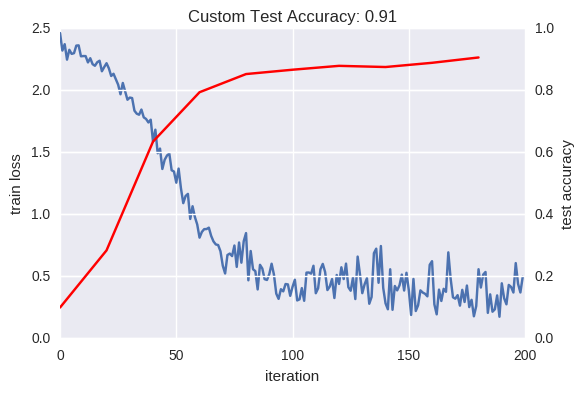

In [4]:
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.get_solver(solver_config_path)
niter = 200  # EDIT HERE increase to train for longer
test_interval = niter / 10
# losses will also be stored in the log
train_loss = np.zeros(niter)
test_acc = np.zeros(int(np.ceil(niter / test_interval)))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(niter), train_loss)
ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Custom Test Accuracy: {:.2f}'.format(test_acc[-1]))

# Start to test robostness of CNN on CIFAR-10 dataset

In [5]:
# solver.solve()
%run res/mInit.py
%matplotlib inline
import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

## Have a look at CIFAR-10

In [6]:
solver=None
solver=caffe.get_solver('cifar/cifar10_quick_solver.prototxt')

In [7]:
# [(k, v.data.shape) for k, v in solver.net.blobs.items()]
for k,v in solver.net.blobs.items():
    print k,v.data.shape
print('\n')    
# [(k, v[0].data.shape) for k, v in solver.net.params.items()]    
for k,v in solver.net.params.items():
    print k,v[0].data.shape,v[1].data.shape

data (200, 3, 32, 32)
label (200,)
conv1 (200, 32, 32, 32)
pool1 (200, 32, 16, 16)
conv2 (200, 32, 16, 16)
pool2 (200, 32, 8, 8)
conv3 (200, 64, 8, 8)
pool3 (200, 64, 4, 4)
ip1 (200, 64)
ip2 (200, 10)
loss ()


conv1 (32, 3, 5, 5) (32,)
conv2 (32, 32, 5, 5) (32,)
conv3 (64, 32, 5, 5) (64,)
ip1 (64, 1024) (64,)
ip2 (10, 64) (10,)


In [8]:
solver.net.forward()

{'loss': array(2.3027663230895996, dtype=float32)}

(-0.5, 31.5, 31.5, -0.5)

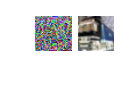

In [9]:
# import cv2
img = solver.net.blobs['data'].data[1]
img = img.transpose(1, 2, 0)
# b,g,r=cv2.split(img)
# img=cv2.merge((r,g,b))
# from pylab import *
# figure(figsize=(1,1))
# imshow(g)
# grid("off")
# axis("off")
# colorbar()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(1,1))
# f, axs = plt.subplots(2,2,figsize=(15,15))
# subplot(121)
# figure(figsize=(1,1))
ax1.imshow(img)
ax1.axis("off")
# colorbar()
blob = caffe.proto.caffe_pb2.BlobProto()
data = open('./cifar/mean.binaryproto', 'rb').read()
blob.ParseFromString(data)
arr = np.array(caffe.io.blobproto_to_array(blob))
out = arr[0]
out = out.transpose(1, 2, 0)
# subplot(122)
# figure(figsize=(1,1))
ax2.imshow(img+out)
ax2.axis("off")
# colorbar()

## Solve
### wrong attempt, one iteration only take 100(batch size) data
how to simulate nosie: bin-->jpg(imageset)-->add permutate noise-->LMBD(use `build/tools/convert_imageset`)。

In [10]:
solver=None
solver=caffe.get_solver('cifar/cifar10_quick_solver.prototxt')
solver.net.forward()

nlabels=solver.net.blobs['label'].data.shape[0]
npnt=1; #TODO -->8 
nattempt=1 #TODO -->5
noisy_frac_arr=[0.2] #TODO np.linspace(0.0,0.7,npnt)
acc_arr=np.zeros((npnt,nattempt))
for idx,noisy_frac in enumerate(noisy_frac_arr):
    ## prepare
    nchange=nlabels*noisy_frac
    nchange=int(nchange)
    ## attempt
    for idx_attempt in np.arange(nattempt):
        solver=None
        solver=caffe.get_solver('cifar/cifar10_quick_solver.prototxt')
        solver.net.forward()
        mask=np.random.permutation(nlabels)[0:nchange]
        mask.sort()
        # print nchange,mask
        # print solver.net.blobs['label'].data
        solver.net.blobs['label'].data[mask]=solver.net.blobs['label'].data[np.random.permutation(mask)]

        solver.solve()
        acc_arr[idx,idx_attempt]=solver.test_nets[0].blobs['accuracy'].data
        # print '\n',solver.net.blobs['label'].data
        
print zip( noisy_frac_arr, acc_arr)

[(0.2, array([ 0.625]))]


-  I think epoch = forward+backford。On the CIFAR-10 dataset, 8 epoches can reach accuracy of 72%, so set max_iter=4000。(where batch_size=100,size of train_set is 5000)
- Consuming time, and contributing to global warmming. QAQ
- For babysitting the hyperparameter I run one epoch first.
- Some Error occur but not affect process 
```
[3118:3151:1005/170036:ERROR:socket_stream.cc(210)] Closing stream with result -100
[3118:3151:1005/170036:ERROR:ssl_client_socket_impl.cc(1141)] handshake failed; returned -1, SSL error code 1, net_error -100
[3118:3151:1005/170036:ERROR:connection_factory_impl.cc(369)] Failed to connect to MCS endpoint with error -100
```

In [13]:
solver=None
solver=caffe.get_solver('cifar/cifar10_quick_solver.prototxt')

npnt=3 #TODO --> 8 
natpt=2 #TODO --> 5
noisy_frac_arr= [ 0, 0.1,  0.2 ]# np.linspace(0.0,0.7,npnt) # --> [ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7]
acc_arr=np.zeros((npnt,natpt))
for i in range(natpt):
    del solver
    solver=None
    solver=caffe.get_solver('cifar/cifar10_quick_solver.prototxt')
    solver.solve()
    acc_arr[0,i]=solver.test_nets[0].blobs['accuracy'].data
    
for idx,noisy_frac in enumerate(noisy_frac_arr[1:]):
    for idx_atpt in range(natpt):
        del solver
        solver=None
        solver=caffe.get_solver('cifar/cifar10_quick_solver_0.'+str(idx+1)+'.prototxt')
        solver.solve()
        acc_arr[idx+1,idx_atpt]=solver.test_nets[0].blobs['accuracy'].data
        # print '\n',solver.net.blobs['label'].data
        
print zip( noisy_frac_arr, acc_arr) 
np.save('./output/acc_arr',acc_arr)

[(0, array([ 0.085,  0.105])), (0.1, array([ 0.105,  0.12 ])), (0.2, array([ 0.105,  0.11 ]))]


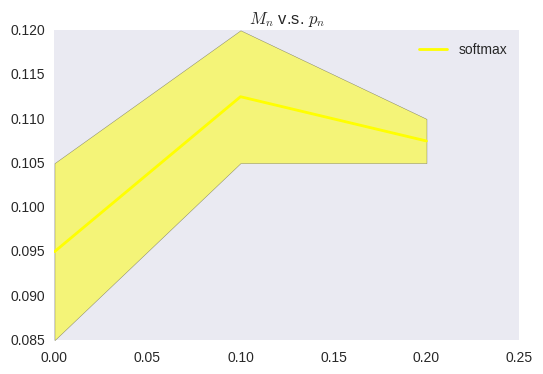

In [14]:
acc_arr=np.load('./output/acc_arr.npy')
mu=acc_arr.mean(1)
sigma=acc_arr.std(1)

fig,ax=plt.subplots(1)
ax.plot(noisy_frac_arr,mu,lw=2,label='softmax',color='yellow')
ax.fill_between(noisy_frac_arr,mu+sigma,mu-sigma,facecolor='yellow',alpha=0.5)
ax.set_title('$M_n$ v.s. $p_n$')
ax.legend(loc='upper right')
ax.grid()